# Introduction

the full competition descrition can be found here https://www.drivendata.org/competitions/2/page/7/

# Preliminary Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Traning_Data.csv',
                         index_col=0, dtype = "float64")
test_data = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Test_Data.csv',
                        index_col=0)
submission_format = pd.read_csv('Warm_Up_Predict_Blood_Donations_-_Submission_Format.csv',
                        index_col=0)

In [3]:
submission_format.index.tolist() == test_data.index.tolist()

True

In [4]:
print train_data.columns.tolist()
print test_data.columns.tolist()

['Months since Last Donation', 'Number of Donations', 'Total Volume Donated (c.c.)', 'Months since First Donation', 'Made Donation in March 2007']
['Months since Last Donation', 'Number of Donations', 'Total Volume Donated (c.c.)', 'Months since First Donation']


In [5]:
train_data.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619.0,2.0,50.0,12500.0,98.0,1.0
664.0,0.0,13.0,3250.0,28.0,1.0
441.0,1.0,16.0,4000.0,35.0,1.0
160.0,2.0,20.0,5000.0,45.0,1.0
358.0,1.0,24.0,6000.0,77.0,0.0


In [6]:
train_data.corr()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
Months since Last Donation,1.000000,-0.159731,-0.159731,0.186899,-0.261234
Number of Donations,-0.159731,1.000000,1.000000,0.622116,0.220615
Total Volume Donated (c.c.),-0.159731,1.000000,1.000000,0.622116,0.220615
Months since First Donation,0.186899,0.622116,0.622116,1.000000,-0.019819
Made Donation in March 2007,-0.261234,0.220615,0.220615,-0.019819,1.000000


It looks like the Total Volume Donated (c.c.) and Number of Donations columns are perfectly correlated

In [7]:
average_donation = train_data["Total Volume Donated (c.c.)"]/train_data["Number of Donations"]
print average_donation.unique()
del average_donation ##so it wouldn't take any unnecessary ram

[ 250.]


Because all the donations are accepted in amount of 250 c.c.. We will drop the Total Volume Donated (c.c.) columns in the further

In [8]:
train_data.isnull().sum(axis=0)

Months since Last Donation     0
Number of Donations            0
Total Volume Donated (c.c.)    0
Months since First Donation    0
Made Donation in March 2007    0
dtype: int64

There are no null values in any of the columns, which makes life a bit easier

In [9]:
for i in train_data.columns.tolist():
    print i, len(train_data[i].unique())

Months since Last Donation 29
Number of Donations 29
Total Volume Donated (c.c.) 29
Months since First Donation 75
Made Donation in March 2007 2


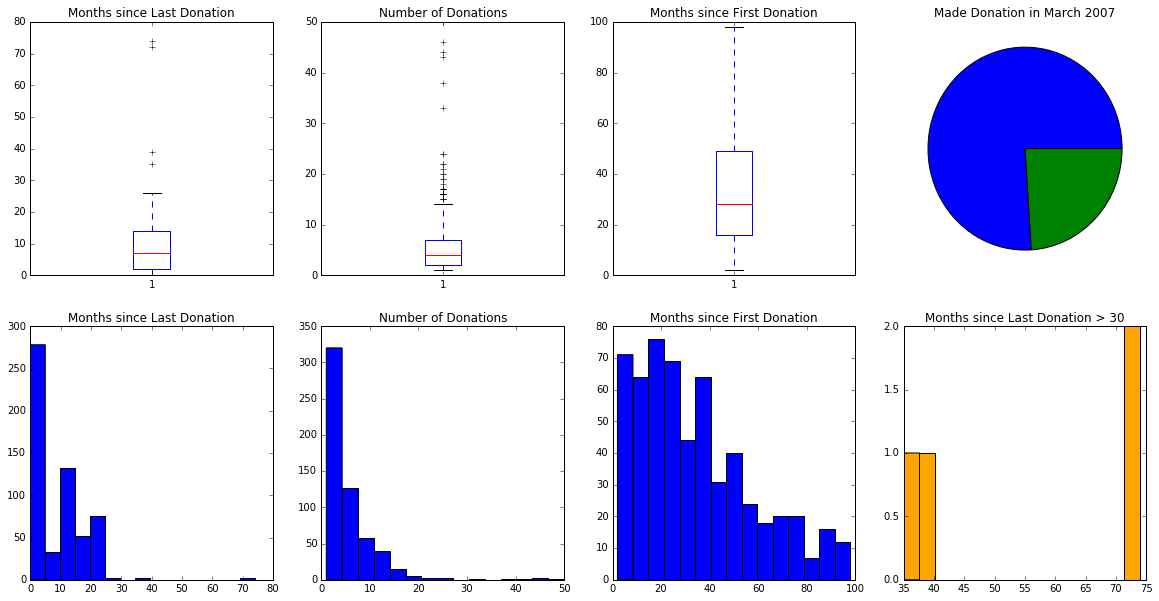

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

axes[0, 0].boxplot(train_data["Months since Last Donation"])
axes[0, 0].set_title("Months since Last Donation")

axes[0, 1].boxplot(train_data["Number of Donations"])
axes[0, 1].set_title("Number of Donations")

axes[0, 2].boxplot(train_data["Months since First Donation"])
axes[0, 2].set_title("Months since First Donation")

axes[0, 3].pie(train_data["Made Donation in March 2007"].value_counts())
axes[0, 3].set_title("Made Donation in March 2007")

axes[1, 0].hist(train_data["Months since Last Donation"], 15)
axes[1, 0].set_title("Months since Last Donation")

axes[1, 1].hist(train_data["Number of Donations"], 15)
axes[1, 1].set_title("Number of Donations")

axes[1, 2].hist(train_data["Months since First Donation"], 15)
axes[1, 2].set_title("Months since First Donation")

axes[1, 3].hist(train_data["Months since Last Donation"][train_data["Months since Last Donation"] > 30], 15, color="orange")
axes[1, 3].set_title("Months since Last Donation > 30")



We are going to split the target variable from the training set in order to have consistency with the test set

In [11]:
train_data[train_data["Months since Last Donation"] > 30]

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
673.0,35.0,3.0,750.0,64.0,0.0
350.0,74.0,1.0,250.0,74.0,0.0
541.0,39.0,1.0,250.0,39.0,0.0
74.0,72.0,1.0,250.0,72.0,0.0


In [12]:
test_data[test_data["Months since Last Donation"] > 30]

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
48,38,1,250,38
491,38,1,250,38
405,40,1,250,40


We will discard records with Months since Last Donation > 30 so they would nor skew any of the coefficients and assign 0% to the in the submission file

# Main Analysis

Delete outliers and separate the target variable from the train set to have consistency with the test set.

In [13]:
train_data = train_data[train_data["Months since Last Donation"] <= 30]
y_train = train_data["Made Donation in March 2007"]
train_data = train_data.drop("Made Donation in March 2007", axis=1)

In [14]:
def fea_gen(data):
    data["donation frequency"] = (data["Months since First Donation"] - data["Months since Last Donation"])/data["Number of Donations"]
    data["last / average"] = data["Months since Last Donation"] / data["donation frequency"]
    data = data.drop("Total Volume Donated (c.c.)", axis=1)   
    data["last / average"] = data["last / average"].replace(np.inf, 5)
    poly = PolynomialFeatures(degree=3, interaction_only=True)
    poly_fea = pd.DataFrame(poly.fit_transform(data), index=data.index.tolist())
    or_col = data.columns.tolist()
    pol_col = poly_fea.columns.tolist()
    data = pd.concat([data, poly_fea],ignore_index = True, axis = 1)
    data.columns= or_col + pol_col
    del poly_fea, or_col, pol_col #to free ram
    return data

Since the algorith will be optimizaed on the training set, we need to set a benchmark. In this case we can use the majority class classifier, which predicts every outcome to be negative i.e. "0"

In [15]:
len(y_train[y_train == 0])/float(len(y_train))

0.7587412587412588

In [16]:
x_train=fea_gen(train_data)

In [17]:
test_data=fea_gen(test_data)

In [18]:
log1 = LogisticRegression(tol=1e-20).fit(x_train,y_train)

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_score(y_train,log1.predict(x_train))

0.79720279720279719

In [21]:
submission_format["Made Donation in March 2007"] = log1.predict_proba(test_data)[:,1]

In [22]:
zeros = test_data[test_data["Months since Last Donation"] > 30].index.tolist()

In [23]:
submission_format.index.tolist() == test_data.index.tolist()

True

In [24]:
submission_format.ix[zeros,:] = 0

In [25]:
submission_format.ix[zeros,:]

,Made Donation in March 2007
48,0.0
491,0.0
405,0.0


In [26]:
submission_format.to_csv("Simple log regression with zeros.csv")

In [27]:
position = 75
participants = 1471
score = 0.4404

print "position {}".format(position)
print "score {}".format(score)
print "in top {0:.{1}%}".format(position/float(participants),0)

position 75
score 0.4404
in top 5%
